In [1]:
from kymotools.detect import Detector
from lumicks import pylake
from scipy.signal import find_peaks

import kymotools.io as kio
import math
import numpy as np
import os
import tifffile

In [2]:
def get_scan_distance(marker, scan):
    """
    Get the distance data for a kymograph.

    :param marker: Pylake File object containing marker data.
    :param kymo: Kymograph object.
    :return: Upsampled distance data.
    """
    marker_time_ns = marker['Force LF']['Trap 1'].timestamps
    marker_distance = marker['Distance']['Distance 1'].data

    if len(scan.timestamps[:][0].shape) > 1:
        print("This script is designed for a scan containing a single timepoint.  Exiting...")
        return None
    
    scan_start_time = min(scan.timestamps[:][0])
    scan_end_time = max(scan.timestamps[:][0])
    scan_time_ns = (marker_time_ns >= scan_start_time) & (marker_time_ns <= scan_end_time)
    scan_distance = np.mean(marker_distance[scan_time_ns])
    
    return scan_distance

def crop_scan_h5(data_folder, scan_name, bead_size=4.35, start_pad=10, bead_pad=0, crop_height=5):
    """
    Process kymographs to detect beads.

    :param data_folder: Path to the data folder.
    :param scan_name: scan.h5 file to process.
    :param bead_size: Size of the beads.
    :param start_pad: Padding at the start of the scan.
    :param bead_pad: Padding either side of bead for cropping.
    :param crop_height: Height of final crop in px.
    """
    adjustment = pylake.ColorAdjustment([0], [10], mode="absolute", gamma=0.5)
    
    scan_file = pylake.File(os.path.join(data_folder, scan_name))
    scan_id = list(scan_file.scans.keys())[0]
    scan = scan_file.scans[scan_id]
    scan_img = scan.get_image()
        
    scan_pixel_size_um = scan.pixelsize_um[0]
    bead_window = int((bead_size /scan_pixel_size_um) * 1.15)

    bead_radius_pixels = (bead_size / scan_pixel_size_um) / 2
    scan_intensity = np.mean(scan_img[:, :, 1], axis=0)
    if start_pad > 0:
        scan_intensity = np.append(scan_intensity[-start_pad:], scan_intensity)

    rolling_mean = np.convolve(scan_intensity, np.ones(bead_window) / bead_window, mode='same')
    bead_peaks = find_peaks(rolling_mean, prominence=0, width=15, height=0, distance=100)
    peak_centres = bead_peaks[0]

    left_bead = peak_centres[0] - start_pad

    scan_distance = get_scan_distance(scan_file, scan)
    if scan_distance is None:
        return None
        
    left_bead_start = (left_bead - bead_radius_pixels)
    left_bead_end = (left_bead + bead_radius_pixels)
    right_bead_start = left_bead_end + (scan_distance/scan_pixel_size_um)
    right_bead_end = left_bead_end + (scan_distance/scan_pixel_size_um) + (bead_radius_pixels * 2)

    # Cropping out beads
    scan_img_crop = scan_img[:,math.ceil(left_bead_end)+bead_pad:math.floor(right_bead_start)-bead_pad,:]

    # Identifying y-position of tether
    scan_img_sumX = np.sum(scan_img_crop,axis=1)
    if (len(scan_img_sumX.shape) > 1):
        scan_img_sumX = np.sum(scan_img_sumX,axis=1)

    detector = Detector(half_t_w=0,peak_det_thresh = 2, n_max=1, a_lb = 0.5, c_lb=1, c_ub=6, c_def=4)
    peaks, rmse = detector.fit_peaks(scan_img_sumX)

    y_centre = round(peaks[1].b)
    if crop_height % 2 == 0:
        crop_height = crop_height + 1
        print("crop_height should be an odd number, increasing to ",crop_height)

    half_h = int((crop_height-1)/2)
    
    return scan_img_crop[y_centre-half_h:y_centre+half_h,:]

def count_foci(scan_img, data_folder, scan_name):
    """
    Count the number of foci in a 1D profile

    :param scan_img: 1D array containing profile to fit.
    :param data_folder: Path to the data folder.
    :param scan_name: Original filename; used to generate output names.
    """
    # Initialising Detector
    detector = Detector(half_t_w=0,peak_det_thresh = 2, n_max=40, a_lb = 0.5, c_lb=1, c_ub=6, c_def=4)

    # Detecting
    peaks, rmse = detector.fit_peaks(scan_img)
    print("RMSE = ",rmse)
            
    # Saving peak data (position, sigma, etc.)
    kio.write_peak_data(peaks, os.path.join(save_folder,scan_name+"_peaks.csv"))

    # Saving peak fit image
    fig = kio.plot_gauss_for_frame(peaks,0,vals=scan_img)
    fig.savefig(os.path.join(save_folder,scan_name+"_peaks.png"))
    

RMSE =  0.646181081854334


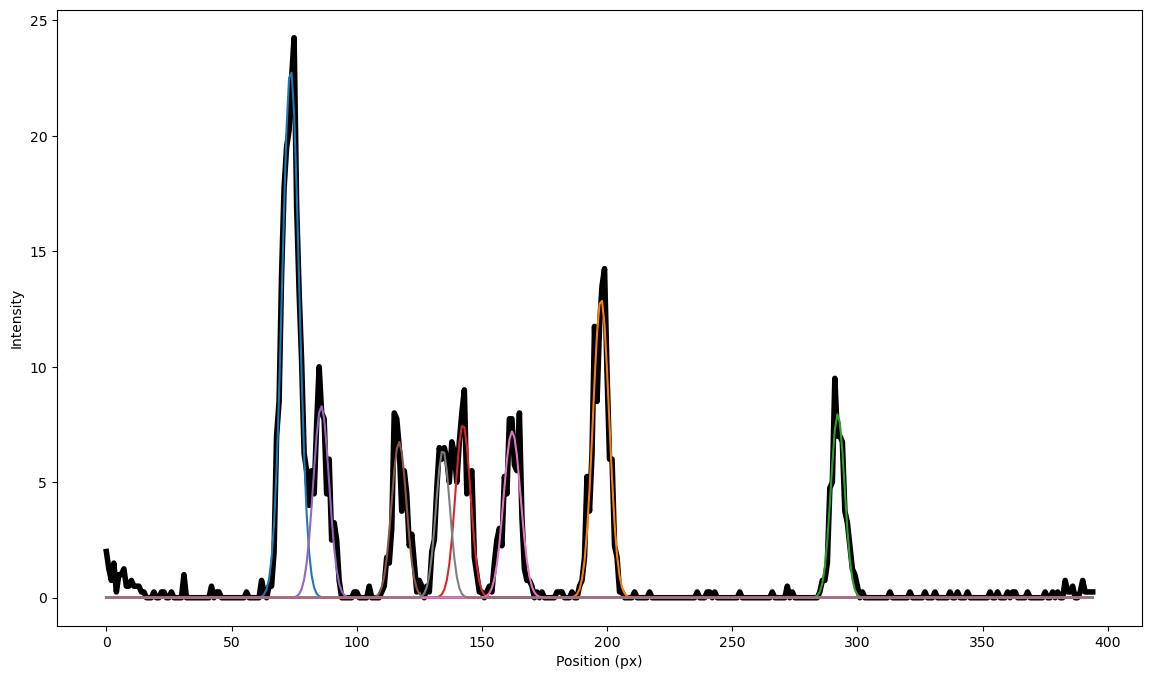

In [3]:
# Define the data folder path and dates to process
data_folder = '../test_folder/'
scan_name = '20240819-141626 Scan 19'
channel = 0
bead_size = 4.35

# Ensuring output folders exist
save_folder = os.path.join(data_folder, 'foci_counts/')
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

# Process the kymographs to detect beads
scan_img = crop_scan_h5(data_folder, scan_name+".h5", bead_size=bead_size, bead_pad=10, crop_height=5)
if scan_img is not None:
    tifffile.imwrite(os.path.join(save_folder,scan_name+"_crop.tif"), scan_img.astype(np.single))
    
    # Reducing to 1D
    scan_img = scan_img[:,:,channel]
    scan_img = np.average(scan_img,axis=0)
    
    # Counting foci
    count_foci(scan_img, data_folder, scan_name)
